# Demo3 : Multimodal Inference Using Claude 3.5 

## Narrating a Video: GPT-4o Vision + Text-to-Speech


### Key Notes 

- `GPT-4o` doesn't take videos as input directly, but we can use vision and the 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:
- Using `GPT-4o` to get a description of a video
- Generating a voiceover for a video with `GPT-4o` and the TTS API



## STEP 1 : Imports and installs 

pip install opencv-python

In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests


## STEP 2 : Setting Open AI Client 

In [2]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "sk-proj-yourkey"))

## STEP 3 : Extract Frames from video 


####  We use OpenCV to extract frames from a Formula One Race [video](https://www.youtube.com/shorts/3h5OLb99OzE)


- In essence, this script captures each frame from the video file "formula_one_silent.webm".
- It converts each frame to JPEG format, encodes it in Base64, and collects all encoded frames in a list.
- At the end of execution, it provides the total count of frames processed.



In [3]:
video = cv2.VideoCapture("formula_one_silent.webm")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

853 frames read.


## STEP 4 :  Display frames to make sure we've read them in correctly

- The list of frames is looped 
- Each frame is then displayed with a small time delay 

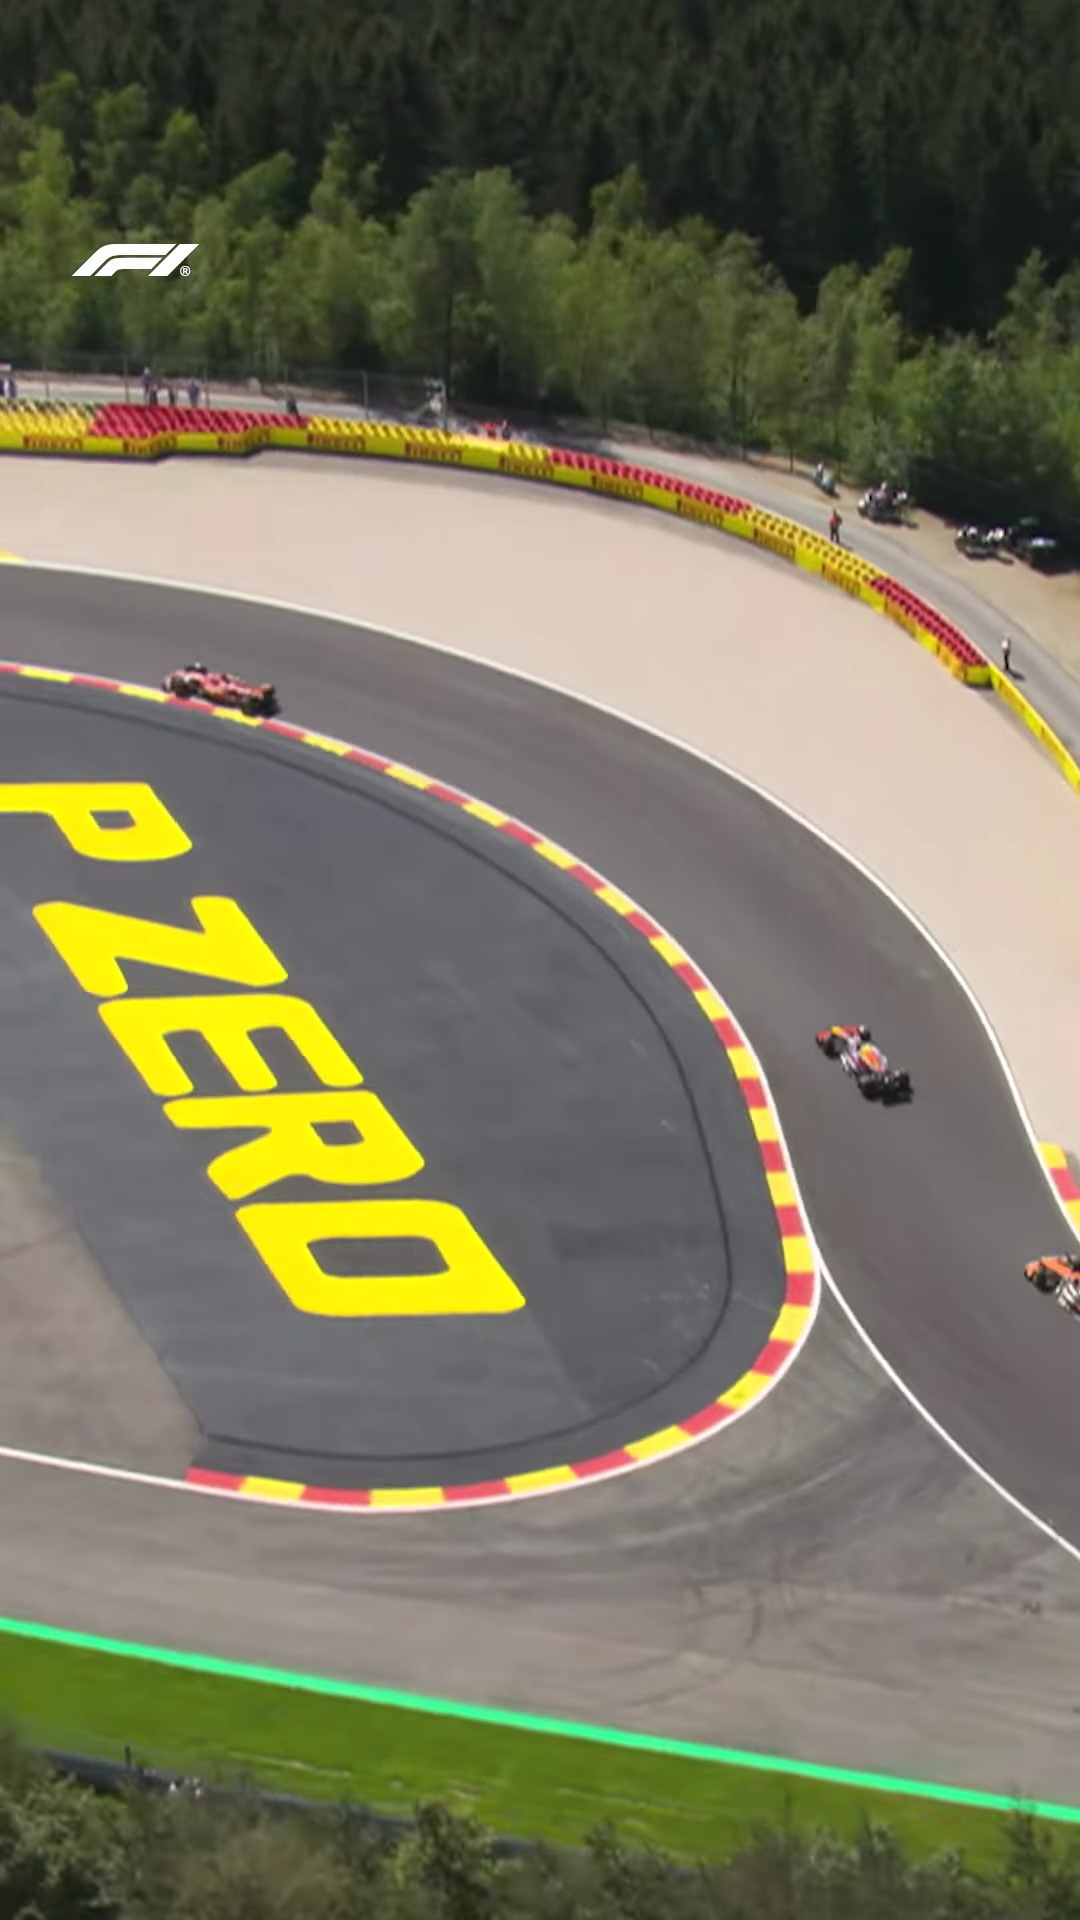

In [8]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

## STEP 5 :  Craft Prompt to extract a short narrative of the video 


- Once we have the video frames, we craft our prompt and send a request to GPT 
- The prompt asks GPT to create a short narrative of the video 


**Note**  We don't need to send every frame for GPT to understand what's going on):

In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Experience the adrenaline of Formula 1 racing with these thrilling highlights! Watch as the cars take on challenging curves and high-speed straights, showcasing the skill and precision of the world's top drivers. Every frame captures the intensity of the race, from heart-pounding overtakes to masterful maneuvers. Don't miss out on this exhilarating ride through one of the most iconic circuits in the world! 🏎️💨 #F1 #Racing #Motorsport #AdrenalineRush


## STEP 6 : Create a voice over text for the video 


**Notes**

- In this step we will  create a voiceover for this video in the style of Ted Kravitz (a great F1 commentator).
- We will provide as inputs the same subset of  video frames we used in a previous step to prompt GPT to give us a short script:

In [6]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of Ted Kravitz. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

We're here at Spa, one of the most iconic tracks on the F1 calendar. As the Mercedes powers down towards Eau Rouge, you can feel the tension in the air. The speed is electrifying, with every corner demanding precision. 

Now, watch as he closes in on the Ferrari ahead, setting up a thrilling battle for position. Down the main straight, it's wheel-to-wheel action! The crowd roars as they go neck-and-neck, the Mercedes just grabbing the edge with a brilliant move on the inside.

It's a masterclass in strategy and execution. This is why Spa always delivers an unforgettable race weekend!


## STEP 7 : Text to Voice Conversion 

**Notes**

- Now we  pass the script to the TTS API where it will generate an mp3 of the voiceover:
- The reponse is generated as chunks 
- The reponse chunks are iterated over and concatenated in a single audio variable 
- The audio is played out using a python package 'Audio' 

In [7]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer sk-proj-your_key",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

### End of Notebook